In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
dataset_dir = "/content/drive/MyDrive/RAVDESS_Audio"
os.listdir(dataset_dir)

['Audio_Song_Actors_01-24.zip', 'Audio_Speech_Actors_01-24.zip']

In [3]:
#Extracting all the files
import zipfile


# Paths to your zip files in Google Drive
speech_zip_path = "/content/drive/MyDrive/RAVDESS_Audio/Audio_Speech_Actors_01-24.zip"
song_zip_path = "/content/drive/MyDrive/RAVDESS_Audio/Audio_Song_Actors_01-24.zip"

# Extract speech files (preserve subfolders)
with zipfile.ZipFile(speech_zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/speech")  # Extracts to /content/speech/Actor_01/, etc.

# Extract song files (preserve subfolders)
with zipfile.ZipFile(song_zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/song")

print("Speech files extracted to:", os.listdir("/content/speech"))
print("Song files extracted to:", os.listdir("/content/song"))

Speech files extracted to: ['Actor_05', 'Actor_21', 'Actor_14', 'Actor_19', 'Actor_18', 'Actor_24', 'Actor_11', 'Actor_10', 'Actor_02', 'Actor_22', 'Actor_06', 'Actor_13', 'Actor_12', 'Actor_01', 'Actor_23', 'Actor_09', 'Actor_15', 'Actor_04', 'Actor_16', 'Actor_08', 'Actor_03', 'Actor_17', 'Actor_20', 'Actor_07']
Song files extracted to: ['Actor_05', 'Actor_21', 'Actor_14', 'Actor_19', 'Actor_18', 'Actor_24', 'Actor_11', 'Actor_10', 'Actor_02', 'Actor_22', 'Actor_06', 'Actor_13', 'Actor_12', 'Actor_01', 'Actor_23', 'Actor_09', 'Actor_15', 'Actor_04', 'Actor_16', 'Actor_08', 'Actor_03', 'Actor_17', 'Actor_20', 'Actor_07']


In [4]:
# Count speech files (should be 1440)
speech_files = []
for actor_dir in os.listdir("/content/speech"):
    actor_path = os.path.join("/content/speech", actor_dir)
    if os.path.isdir(actor_path):
        speech_files.extend(os.listdir(actor_path))
print(f"Total speech files: {len(speech_files)}")

# Count song files (should be 1012)
song_files = []
for actor_dir in os.listdir("/content/song"):
    actor_path = os.path.join("/content/song", actor_dir)
    if os.path.isdir(actor_path):
        song_files.extend(os.listdir(actor_path))
print(f"Total song files: {len(song_files)}")

Total speech files: 1440
Total song files: 1012


In [5]:
import pandas as pd

# Mapping from ID to emotion label
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [6]:
#Extracting useful info from metadata

def parse_filename(filepath, file_type):
    filename = os.path.basename(filepath)
    parts = filename.split('.')[0].split('-')
    emotion = emotion_map[parts[2]]
    actor_id = int(parts[-1])
    gender = 'female' if actor_id % 2 == 0 else 'male'

    return {
        'file_path': filepath,
        'emotion': emotion,
        'actor': actor_id,
        'gender': gender,
        'type': file_type  # speech or song
    }

data = []

# Speech files
for actor_dir in os.listdir("/content/speech"):
    actor_path = os.path.join("/content/speech", actor_dir)
    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                full_path = os.path.join(actor_path, file)
                data.append(parse_filename(full_path, "speech"))

# Song files
for actor_dir in os.listdir("/content/song"):
    actor_path = os.path.join("/content/song", actor_dir)
    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                full_path = os.path.join(actor_path, file)
                data.append(parse_filename(full_path, "song"))

# Create merged DataFrame
df = pd.DataFrame(data)
print(df.head())
print("Total samples:", len(df))
print("Emotion counts:\n", df['emotion'].value_counts())
print("Type distribution:\n", df['type'].value_counts())


                                           file_path    emotion  actor gender  \
0  /content/speech/Actor_05/03-01-05-01-01-01-05.wav      angry      5   male   
1  /content/speech/Actor_05/03-01-08-02-02-02-05.wav  surprised      5   male   
2  /content/speech/Actor_05/03-01-01-01-01-02-05.wav    neutral      5   male   
3  /content/speech/Actor_05/03-01-08-02-01-02-05.wav  surprised      5   male   
4  /content/speech/Actor_05/03-01-06-01-01-02-05.wav    fearful      5   male   

     type  
0  speech  
1  speech  
2  speech  
3  speech  
4  speech  
Total samples: 2452
Emotion counts:
 emotion
angry        376
fearful      376
happy        376
sad          376
calm         376
surprised    192
disgust      192
neutral      188
Name: count, dtype: int64
Type distribution:
 type
speech    1440
song      1012
Name: count, dtype: int64


In [7]:
#Actor 18 song files missing and all other files processed properly
df['actor'].value_counts()

,count
actor,
5,104
21,104
14,104
19,104
24,104
11,104
10,104
2,104
15,104


In [8]:
!pip install librosa

In [18]:
import librosa
import numpy as np

def extract_features_dl(file_path, n_mfcc=40, max_len=200):
    y, sr = librosa.load(file_path, sr=22050)

    # Extract MFCC and Delta
    # NEW VERSION (MFCC only)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    combined = mfcc  # Shape: [n_mfcc, T]

    # Pad or truncate to max_len time steps
    if combined.shape[1] < max_len:
        pad_width = max_len - combined.shape[1]
        combined = np.pad(combined, ((0, 0), (0, pad_width)), mode='constant')
    else:
        combined = combined[:, :max_len]

    return combined


In [30]:
from tqdm import tqdm
X_dl = []
y_dl = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        features = extract_features_dl(row['file_path'], n_mfcc=40, max_len=300)
        X_dl.append(features)
        y_dl.append(row['emotion'])
    except Exception as e:
        print(f"Error processing {row['file_path']}: {e}")

# Convert to NumPy arrays
X_dl = np.array(X_dl)
y_dl = np.array(y_dl)

# Reshape for CNN: [samples, n_mfcc*2, time_steps, channels]
X_dl = X_dl[..., np.newaxis]  # Add channel dim
print("X shape:", X_dl.shape)


100%|██████████| 2452/2452 [00:39<00:00, 62.18it/s]

X shape: (2452, 40, 300, 1)


In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import random
import numpy as np
import tensorflow as tf



# Encode labels
le_dl = LabelEncoder()
y_encoded_dl = le_dl.fit_transform(y_dl)
y_categorical = to_categorical(y_encoded_dl)

# 80-20 Split
X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(
    X_dl, y_categorical, test_size=0.2, stratify=y_encoded_dl, random_state=42
)

print("Train:", X_train_dl.shape)
print("Val:", X_val_dl.shape)


Train: (1961, 40, 300, 1)
Val: (491, 40, 300, 1)


In [32]:


input_shape = (40, 300, 1)
num_classes = y_train_dl.shape[1]

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, 300, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),  # ✅ instead of Flatten()
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 38, 298, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 38, 298, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 19, 149, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 17, 147, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 17, 147, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 73, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 71, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 71, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 35, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,112 (434.03 KB)

 Trainable params: 110,664 (432.28 KB)

 Non-trainable params: 448 (1.75 KB)

In [41]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_encoded_dl), y=y_encoded_dl)
class_weights_dict = dict(enumerate(class_weights))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=30,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)


Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.9512 - loss: 0.1285 - val_accuracy: 0.7128 - val_loss: 0.9243
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9782 - loss: 0.0734 - val_accuracy: 0.6191 - val_loss: 1.1379
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9774 - loss: 0.0578 - val_accuracy: 0.7067 - val_loss: 0.9454
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9924 - loss: 0.0409 - val_accuracy: 0.6558 - val_loss: 1.3213
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9825 - loss: 0.0538 - val_accuracy: 0.7902 - val_loss: 0.7371
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9666 - loss: 0.0955 - val_accuracy: 0.5193 - val_loss: 2.3163
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9677 - loss: 0.1081 - val_accuracy: 0.7495 - val_loss: 0.8225
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9626 - loss: 0.0972 - val_accuracy: 0.6477 - v

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
              precision    recall  f1-score   support

       angry       0.92      0.91      0.91        75
        calm       0.87      0.91      0.89        75
     disgust       0.85      0.85      0.85        39
     fearful       0.80      0.69      0.74        75
       happy       0.77      0.89      0.83        75
     neutral       0.96      0.68      0.80        38
         sad       0.82      0.77      0.79        75
   surprised       0.72      0.92      0.81        39

    accuracy                           0.83       491
   macro avg       0.84      0.83      0.83       491
weighted avg       0.84      0.83      0.83       491



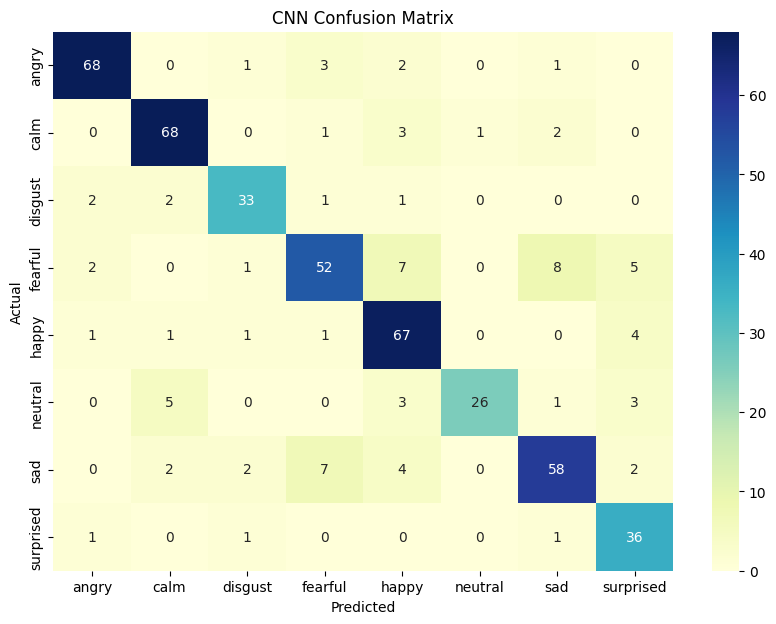

In [42]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on validation set
y_pred_val = model.predict(X_val_dl)
y_pred_labels = np.argmax(y_pred_val, axis=1)
y_true_labels = np.argmax(y_val_dl, axis=1)

# Classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=le_dl.classes_))

# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le_dl.classes_, yticklabels=le_dl.classes_, cmap='YlGnBu')
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
model.save("emotion_cnn_model_2.h5")


In [ ]:
import joblib

joblib.dump(le_dl, "label_encoder.pkl")


['label_encoder.pkl']